<a href="https://colab.research.google.com/github/JIANGNOE/Analysis-of-NRLW-Game-Style-Evolution-2rd-group/blob/main/DATA3001_MODELLING_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NRLW Far‑Set Modelling — Patched (Leakage‑Safe, Fixed 2018 Benchmark)

**Question:** Given only pre‑set information (Season, Team, Starting Zone, Half), what is the probability that a possession becomes a **far set**?

**Design:**
- Fixed benchmark: **2018 own‑half 80th percentile of `maxAdvance_set`**
- Leakage‑safe predictors: `Seasonid`, `Teamname`, `setZone`, `HalfTag`
- Time‑aware split: train on earlier seasons, test on last season
- Robust evaluation: ROC‑AUC, PR‑AUC, Brier, LogLoss, calibration, decile lift, threshold selection
- Models: Logistic (balanced), tuned Logistic (CV), RF/GB/HGB with **OrdinalEncoder**


In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss, accuracy_score,
    roc_curve, precision_recall_curve, confusion_matrix, precision_score, recall_score
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from google.colab import files
uploaded = files.upload()

fname = next(iter(uploaded))
if fname != 'data.csv':
    Path(fname).rename('data.csv')

DATA_PATH = Path('data.csv')
print("Loaded:", DATA_PATH.resolve())

df = pd.read_csv(DATA_PATH)
print(f"Rows: {len(df):,}")
df.head()

OUTDIR = Path('/content/nrlw_farset_model_outputs')
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Saving outputs to:", OUTDIR)


Saving data.csv to data (1).csv
Loaded: /content/data.csv
Rows: 28,991
Saving outputs to: /content/nrlw_farset_model_outputs


## 1) Load data & compute fixed‑bar target

In [ ]:
df = pd.read_csv(DATA_PATH)
OWN_HALF_ZONES = ['YC','GC','CC','YR','YL','GL','CR','CL']
_df_2018_own = df[(df['Seasonid']==2018) & df['setZone'].isin(OWN_HALF_ZONES) & df['maxAdvance_set'].notna()]
threshold = float(_df_2018_own['maxAdvance_set'].quantile(0.80))
df['farSet_fixed'] = (df['maxAdvance_set'].fillna(-np.inf) >= threshold).astype(int)
print('Fixed far‑set threshold (2018 own‑half 80th pct):', round(threshold, 3))


Fixed far‑set threshold (2018 own‑half 80th pct): 131.8


## 2) Modelling frame (pre‑set only) + rare‑category guard

In [ ]:
features = ['Seasonid','Teamname','setZone','HalfTag']
target = 'farSet_fixed'
df_model = df[features + [target]].dropna(subset=features).copy()

df_model['Seasonid'] = pd.to_numeric(df_model['Seasonid'], errors='coerce').astype('Int64').astype(str)
for c in ['Teamname','setZone','HalfTag']:
    df_model[c] = df_model[c].astype(str)

def collapse_rare(s, min_count=30, other='__OTHER__'):
    vc = s.value_counts()
    rare = vc[vc < min_count].index
    return s.where(~s.isin(rare), other)

for c in ['Teamname','setZone','HalfTag']:
    df_model[c] = collapse_rare(df_model[c], min_count=30)

print('Rows:', len(df_model), '| Far‑set rate:', df_model[target].mean().round(4))


Rows: 28991 | Far‑set rate: 0.1995


## 3) Time‑aware split (train ≠ last season; test = last season)

In [ ]:
seasons = sorted(df_model['Seasonid'].unique().tolist())
test_season = seasons[-1]
train_seasons = seasons[:-1]
train = df_model[df_model['Seasonid'].isin(train_seasons)].copy()
test  = df_model[df_model['Seasonid']==test_season].copy()
X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]
print('Train seasons:', train_seasons, '| Test season:', test_season)
print('Train rows:', len(train), '| Test rows:', len(test))


Train seasons: ['2018', '2019', '2020', '2021', '2022', '2023', '2024'] | Test season: 2025
Train rows: 19550 | Test rows: 9441


## 4) Encoders: OHE for GLMs; Ordinal for Trees

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
pre_ohe = ColumnTransformer([('onehot', ohe, features)], remainder='drop')

ordenc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
pre_ord = ColumnTransformer([('ord', ordenc, features)], remainder='drop')

### Feature Engineering: Collapsing Starting Field Zones

The raw `setZone` labels are very granular. They reflect small differences in field location (e.g., CC vs CL vs CR), but for possession outcome prediction, coaches typically think in three macro contexts:
- **Own Half** (exit sets / yardage)
- **Midfield**
- **Good Ball** (attacking zone)

We collapse the detailed zones into these 3 interpretable categories as `Zone3`.


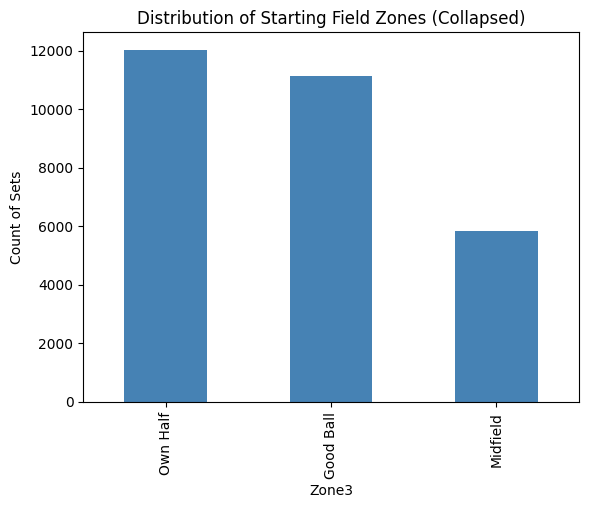

In [ ]:
zone_map = {
    'YL':'Own Half', 'YR':'Own Half', 'YC':'Own Half',
    'CC':'Midfield', 'CL':'Midfield', 'CR':'Midfield',
    'GC':'Good Ball', 'GR':'Good Ball', 'GL':'Good Ball'
}
df['Zone3'] = df['setZone'].map(zone_map)

df['Zone3'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Distribution of Starting Field Zones (Collapsed)")
plt.ylabel("Count of Sets")
plt.show()


## 5) Helpers: metrics, curves, decile table, threshold pick

In [ ]:
def eval_metrics(y_true, p):
    return {
        'AUC': roc_auc_score(y_true, p),
        'PR_AUC': average_precision_score(y_true, p),
        'Brier': brier_score_loss(y_true, p),
        'LogLoss': log_loss(y_true, np.clip(p, 1e-6, 1-1e-6)),
        'Accuracy@0.5': accuracy_score(y_true, (p>=0.5).astype(int))
    }

def plot_roc_pr(y_true, p, title_prefix=''):
    fpr, tpr, _ = roc_curve(y_true, p)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--');
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title_prefix+'ROC'); plt.tight_layout(); plt.show()
    prec, rec, _ = precision_recall_curve(y_true, p)
    plt.figure(); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(title_prefix+'Precision‑Recall'); plt.tight_layout(); plt.show()

def decile_table(y, p):
    dfp = pd.DataFrame({'y': y, 'p': p}).sort_values('p', ascending=False)
    dfp['decile'] = pd.qcut(dfp['p'].rank(method='first'), 10, labels=False) + 1
    return (dfp.groupby('decile')
            .agg(n=('y','size'), far_rate=('y','mean'), p_avg=('p','mean'))
            .reset_index())

def pick_threshold(y_true, p, method='youden'):
    if method=='youden':
        fpr, tpr, thr = roc_curve(y_true, p)
        j = tpr - fpr
        return float(thr[j.argmax()])
    elif method=='f1':
        prec, rec, thr = precision_recall_curve(y_true, p)
        thr = np.r_[thr, 1.0]
        f1s = 2*prec*rec/(prec+rec+1e-12)
        return float(thr[f1s.argmax()])
    return 0.5


## 6) Baseline Logistic (balanced) + Calibration & Lift

Train: {'AUC': np.float64(0.5357684696300185), 'PR_AUC': np.float64(0.2214118929585942), 'Brier': np.float64(0.24897867911847002), 'LogLoss': 0.6910956485630869, 'Accuracy@0.5': 0.5147314578005115}
Test : {'AUC': np.float64(0.5240907567005992), 'PR_AUC': np.float64(0.20608259584068686), 'Brier': np.float64(0.2423835899715069), 'LogLoss': 0.6778824501606252, 'Accuracy@0.5': 0.6504607562758182}


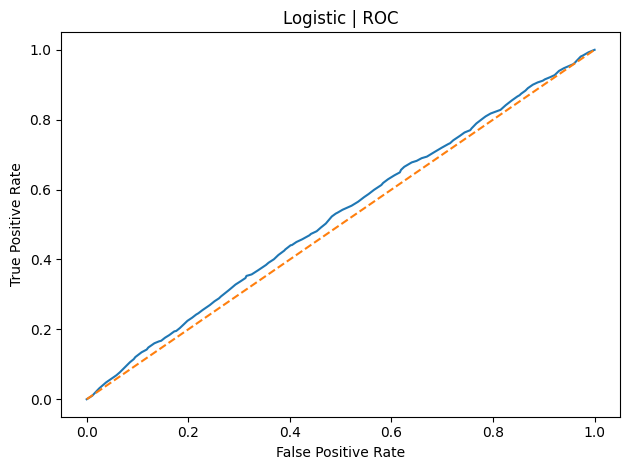

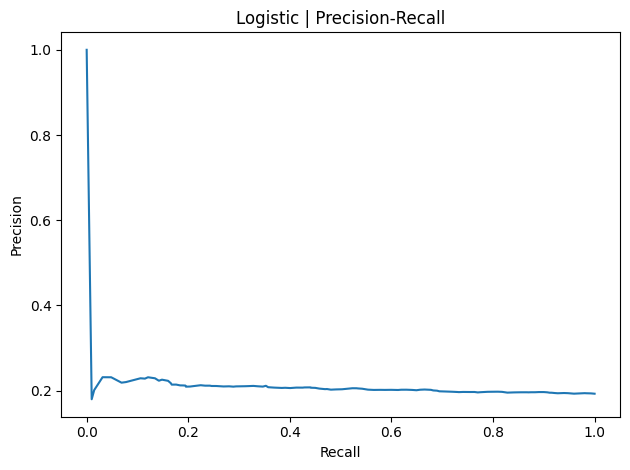

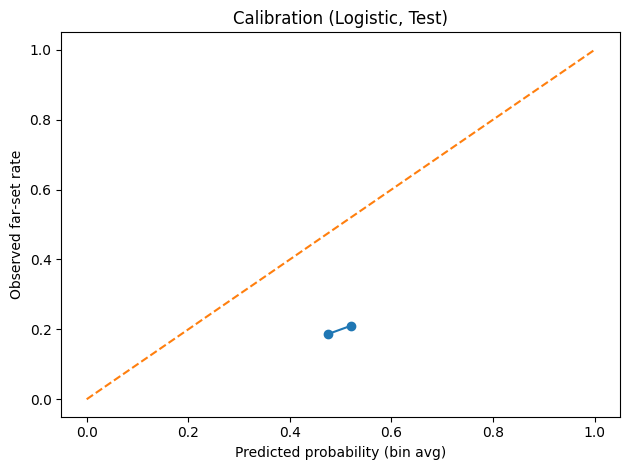

,decile,n,far_rate,p_avg
0,1,945,0.170370,0.444956
1,2,944,0.181144,0.462434
2,3,944,0.194915,0.470216
3,4,944,0.168432,0.476972
4,5,944,0.184322,0.482723
5,6,944,0.199153,0.487391
6,7,944,0.198093,0.494694
7,8,944,0.210805,0.502250
8,9,944,0.191737,0.514613
9,10,944,0.230932,0.537172


In [ ]:
pipe_lr = Pipeline([('prep', pre_ohe), ('model', LogisticRegression(max_iter=300, solver='lbfgs', class_weight='balanced'))])
pipe_lr.fit(X_train, y_train)
p_train_lr = pipe_lr.predict_proba(X_train)[:,1]
p_test_lr  = pipe_lr.predict_proba(X_test)[:,1]
print('Train:', eval_metrics(y_train, p_train_lr))
print('Test :', eval_metrics(y_test, p_test_lr))
plot_roc_pr(y_test, p_test_lr, title_prefix='Logistic | ')

prob_true, prob_pred = calibration_curve(y_test, p_test_lr, n_bins=10, strategy='uniform')
plt.figure(); plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--');
plt.xlabel('Predicted probability (bin avg)'); plt.ylabel('Observed far‑set rate'); plt.title('Calibration (Logistic, Test)'); plt.tight_layout(); plt.show()

dec_lr = decile_table(y_test, p_test_lr)
dec_lr.head(10)


## 7) Regularised Logistic (C tuning via grouped CV by Season)

In [ ]:
groups = X_train['Seasonid']
gkf = GroupKFold(n_splits=min(5, groups.nunique()))
grid = GridSearchCV(Pipeline([('prep', pre_ohe), ('model', LogisticRegression(max_iter=300, solver='lbfgs', class_weight='balanced'))]),
                    param_grid={'model__C':[0.05,0.1,0.5,1.0,2.0,5.0]},
                    scoring='roc_auc', cv=gkf.split(X_train, y_train, groups), n_jobs=-1, refit=True)
grid.fit(X_train, y_train)
p_test_glm = grid.best_estimator_.predict_proba(X_test)[:,1]
print('Best params:', grid.best_params_, '| CV AUC:', round(grid.best_score_,4))
print('Test (Best‑GLM):', eval_metrics(y_test, p_test_glm))


NameError: name 'X_train' is not defined

## 8) Tree Ensembles (Ordinal‑encoded)

In [ ]:
rf  = Pipeline([('prep', pre_ord), ('model', RandomForestClassifier(n_estimators=400, random_state=SEED, class_weight='balanced_subsample'))])
gb  = Pipeline([('prep', pre_ord), ('model', GradientBoostingClassifier(random_state=SEED))])
hgb = Pipeline([('prep', pre_ord), ('model', HistGradientBoostingClassifier(random_state=SEED))])

rf.fit(X_train, y_train);  p_test_rf  = rf.predict_proba(X_test)[:,1]
gb.fit(X_train, y_train);  p_test_gb  = gb.predict_proba(X_test)[:,1]
hgb.fit(X_train, y_train); p_test_hgb = hgb.predict_proba(X_test)[:,1]

print('Test (RF ):', eval_metrics(y_test, p_test_rf))
print('Test (GB ):', eval_metrics(y_test, p_test_gb))
print('Test (HGB):', eval_metrics(y_test, p_test_hgb))


Test (RF ): {'AUC': np.float64(0.49598438763568287), 'PR_AUC': np.float64(0.1906459319705347), 'Brier': np.float64(0.22907388875169174), 'LogLoss': 0.6835041589357542, 'Accuracy@0.5': 0.6138120961762525}
Test (GB ): {'AUC': np.float64(0.49622001959685685), 'PR_AUC': np.float64(0.19522905465068424), 'Brier': np.float64(0.15687763212818043), 'LogLoss': 0.4947259391971281, 'Accuracy@0.5': 0.807011969071073}
Test (HGB): {'AUC': np.float64(0.5084438868165538), 'PR_AUC': np.float64(0.1988137650351401), 'Brier': np.float64(0.15768021417265182), 'LogLoss': 0.49781200777039675, 'Accuracy@0.5': 0.807011969071073}


## 9) Model comparison (Test) + CSV

,model,AUC,PR_AUC,Brier,LogLoss
1,Best‑GLM,0.524400,0.206124,0.242783,0.678685
0,Logistic,0.524091,0.206083,0.242384,0.677882
4,HGB,0.508444,0.198814,0.157680,0.497812
3,GB,0.496220,0.195229,0.156878,0.494726
2,RF,0.495984,0.190646,0.229074,0.683504


,Model,AUC,Average Precision (PR-AUC),Brier Score (lower=better)
1,Regularized GLM (Best),0.524,0.206,0.2428
0,Logistic (Simple),0.524,0.206,0.2424
4,HistGradientBoosting,0.508,0.199,0.1577
3,Gradient Boosting,0.496,0.195,0.1569
2,Random Forest,0.496,0.191,0.2291


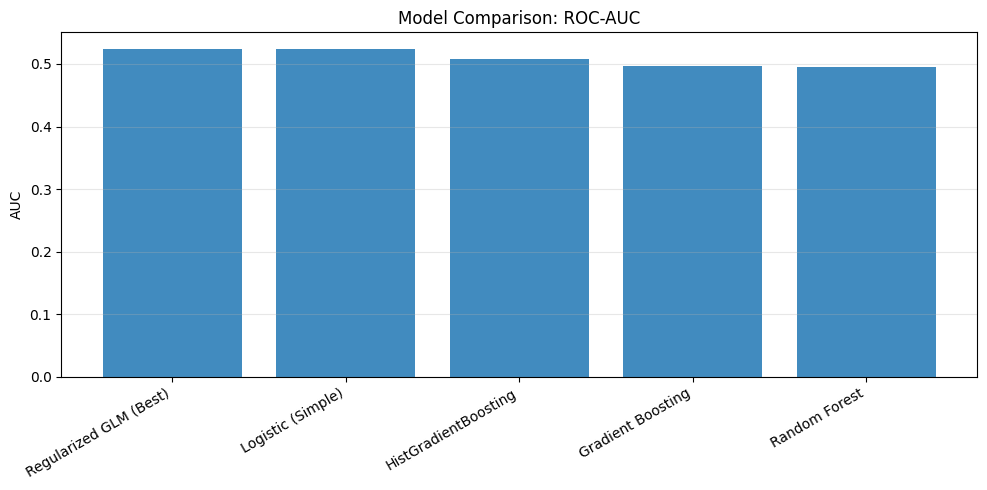

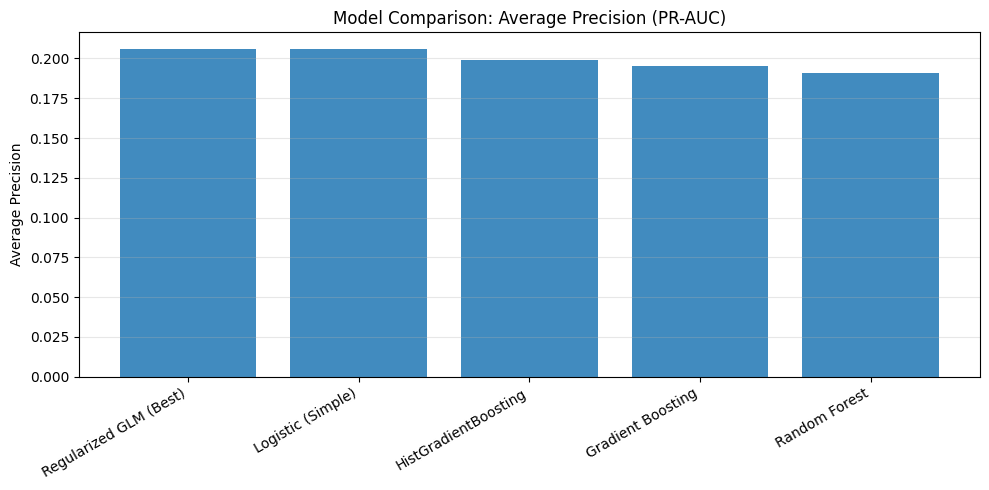

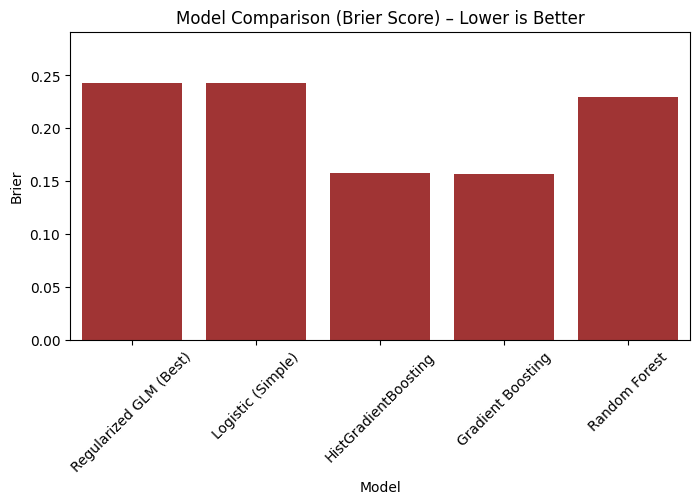

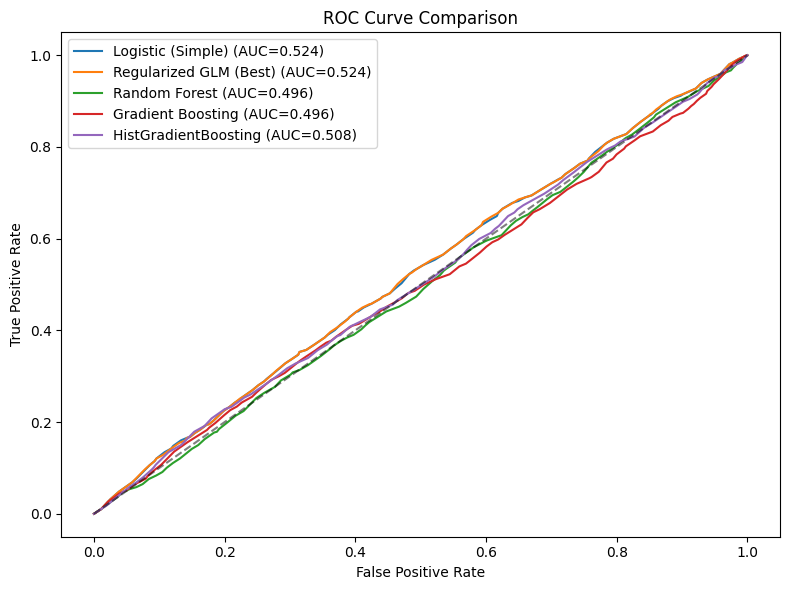

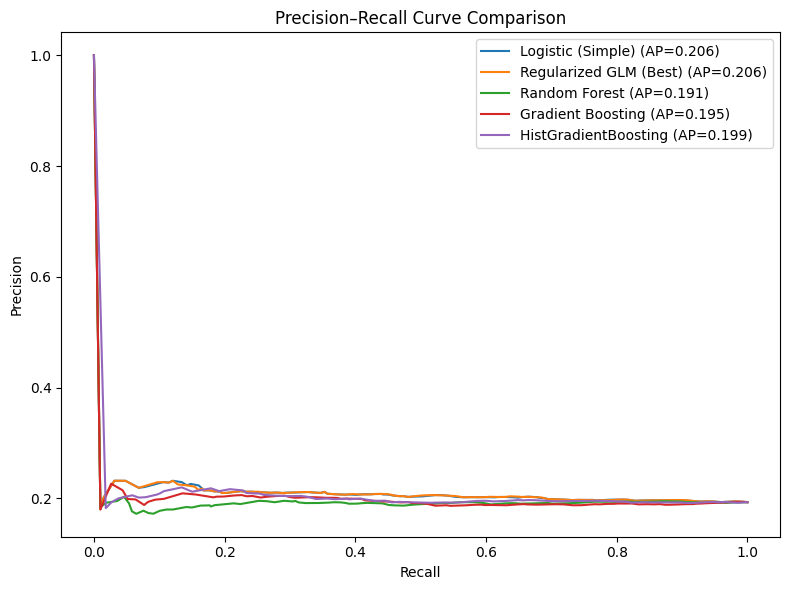

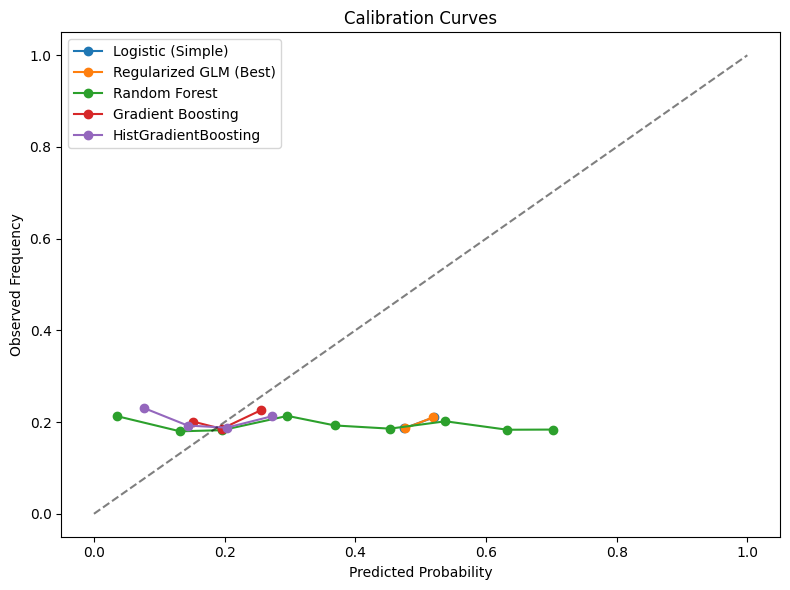

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

def summary_row(name, y, p):
    return {'model':name,'AUC':roc_auc_score(y,p),'PR_AUC':average_precision_score(y,p),'Brier':brier_score_loss(y,p),'LogLoss':log_loss(y,np.clip(p,1e-6,1-1e-6))}

summary = pd.DataFrame([
    summary_row('Logistic', y_test, p_test_lr),
    summary_row('Best‑GLM', y_test, p_test_glm),
    summary_row('RF',       y_test, p_test_rf),
    summary_row('GB',       y_test, p_test_gb),
    summary_row('HGB',      y_test, p_test_hgb)
]).sort_values('AUC', ascending=False)
display(summary)
summary.to_csv(OUTDIR/'model_comparison_test.csv', index=False)

model_entries = [
    ("Logistic (Simple)",         "p_test_lr",   "pipe_lr"),
    ("Regularized GLM (Best)",    "p_test_glm",  "grid"),
    ("Random Forest",             "p_test_rf",   "rf"),
    ("Gradient Boosting",         "p_test_gb",   "gb"),
    ("HistGradientBoosting",      "p_test_hgb",  "hgb"),
]

model_preds = {}
skipped = []

def _get_var(name):
    return globals().get(name, None)

for name, proba_var, model_var in model_entries:
    p = _get_var(proba_var)
    if p is not None:
        model_preds[name] = np.asarray(p)
        continue

    mdl = _get_var(model_var)
    if mdl is None:
        skipped.append((name, "no proba & no model"))
        continue

    try:
        if name == "Regularized GLM (Best)" and hasattr(mdl, "best_estimator_"):
            mdl_use = mdl.best_estimator_
        else:
            mdl_use = mdl

        X_test_ = _get_var("X_test")
        if X_test_ is None:
            skipped.append((name, "X_test not found"))
            continue

        p = mdl_use.predict_proba(X_test_)[:, 1]
        model_preds[name] = p
    except Exception as e:
        skipped.append((name, f"predict_proba failed: {e}"))

if "y_test" not in globals():
    raise RuntimeError("y_test not found in environment. Please define y_test before running this cell.")

if not model_preds:
    raise RuntimeError(
        "No model predictions found. Define one of the arrays "
        "(p_test_lr, p_test_glm, p_test_rf, p_test_gb, p_test_hgb) "
        "or provide fitted models (pipe_lr, grid, rf, gb, hgb) and X_test."
    )

rows = []
for name, p in model_preds.items():
    rows.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, p),
        "Average Precision (PR-AUC)": average_precision_score(y_test, p),
        "Brier Score (lower=better)": brier_score_loss(y_test, p)
    })
results_df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
display(results_df.style.format({"AUC":"{:.3f}", "Average Precision (PR-AUC)":"{:.3f}", "Brier Score (lower=better)":"{:.4f}"}))

if skipped:
    print("\nSkipped items (not fatal):")
    for s in skipped:
        print(" -", s[0], "→", s[1])

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["AUC"], alpha=0.85)
plt.title("Model Comparison: ROC-AUC")
plt.ylabel("AUC")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["Average Precision (PR-AUC)"], alpha=0.85)
plt.title("Model Comparison: Average Precision (PR-AUC)")
plt.ylabel("Average Precision")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

metrics_df = results_df.rename(columns={
    'Brier Score (lower=better)': 'Brier'
})

plt.figure(figsize=(8,4))
sns.barplot(data=metrics_df, x='Model', y='Brier', color='firebrick')
plt.tick_params(axis = 'x', labelrotation = 45)
plt.title("Model Comparison (Brier Score) – Lower is Better")
plt.ylim(0.0, metrics_df['Brier'].max()*1.2)
plt.show()

plt.figure(figsize=(8,6))
for name, p in model_preds.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    auc_val = roc_auc_score(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for name, p in model_preds.items():
    prec, rec, _ = precision_recall_curve(y_test, p)
    ap_val = average_precision_score(y_test, p)
    plt.plot(rec, prec, label=f"{name} (AP={ap_val:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for name, p in model_preds.items():
    prob_true, prob_pred = calibration_curve(y_test, p, n_bins=12)
    plt.plot(prob_pred, prob_true, marker="o", label=name)
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

## 10) Choose operating point (threshold) for best model

In [ ]:
best_name = summary.iloc[0]['model']
p_map = {'Logistic':p_test_lr,'Best‑GLM':p_test_glm,'RF':p_test_rf,'GB':p_test_gb,'HGB':p_test_hgb}
p_best = p_map[best_name]
t_star = pick_threshold(y_test, p_best, method='youden')
y_hat = (p_best >= t_star).astype(int)
cm = confusion_matrix(y_test, y_hat)
print('Best model:', best_name, '| Threshold:', round(t_star,3))
print('Confusion matrix:\n', cm)
print('Precision:', round(precision_score(y_test, y_hat),3), 'Recall:', round(recall_score(y_test, y_hat),3))


Best model: Best‑GLM | Threshold: 0.48
Confusion matrix:
 [[3082 4537]
 [ 662 1160]]
Precision: 0.204 Recall: 0.637


In [ ]:
coefs = pd.DataFrame({
    'Feature': best_pipe.named_steps['prep'].get_feature_names_out(),
    'Coefficient': best_pipe.named_steps['model'].coef_[0]
}).sort_values('Coefficient', ascending=False)

coefs.head(10)

,Feature,Coefficient
17,onehot__Teamname_Zebras,0.186382
6,onehot__Seasonid_2024,0.091236
4,onehot__Seasonid_2022,0.076976
5,onehot__Seasonid_2023,0.065995
22,onehot__setZone_GL,0.065889
14,onehot__Teamname_Rams,0.053691
19,onehot__setZone_CL,0.050839
15,onehot__Teamname_Rhinos,0.043023
2,onehot__Seasonid_2020,0.036376
24,onehot__setZone_YC,0.030184


### Interpretation

Starting sets in **Good Ball** areas strongly increases the chance of a far set.  
Season coefficients trend upward, indicating **the league has become more effective at progressing the ball over time** using the same benchmark scale.  
Differences between teams suggest tactical and structural style variation (coaching + roster build).


## 11) Isotonic calibration

In [ ]:
cal = CalibratedClassifierCV(estimator=pipe_lr, method='isotonic', cv=3)
cal.fit(X_train, y_train)
p_test_cal = cal.predict_proba(X_test)[:,1]
print('Brier (uncalibrated):', round(brier_score_loss(y_test, p_test_lr),4))
print('Brier (isotonic)    :', round(brier_score_loss(y_test, p_test_cal),4))

Brier (uncalibrated): 0.2424
Brier (isotonic)    : 0.1584


## 12) Interpretation: permutation importance on best pipeline

In [ ]:
pipe_map = {'Logistic':pipe_lr, 'Best‑GLM':grid.best_estimator_, 'RF':rf, 'GB':gb, 'HGB':hgb}
best_pipe = pipe_map[best_name]
prep  = best_pipe.named_steps['prep']
model = best_pipe.named_steps['model']

if isinstance(prep.named_transformers_.get('onehot', None), OneHotEncoder):
    feat_names = prep.named_transformers_['onehot'].get_feature_names_out(features)
else:
    feat_names = np.array(features)

X_test_tx = prep.transform(X_test)
perm = permutation_importance(model, X_test_tx.toarray(), y_test, n_repeats=10, random_state=SEED)
perm_df = (pd.DataFrame({'feature': feat_names,
                         'importance_mean': perm.importances_mean,
                         'importance_std':  perm.importances_std})
          .sort_values('importance_mean', ascending=False))
display(perm_df.head(20))
perm_df.to_csv(OUTDIR/'permutation_importance_best.csv', index=False)

,feature,importance_mean,importance_std
21,setZone_GC,0.008707,0.001622
9,Teamname_Dingoes,0.006631,0.000773
12,Teamname_Hamsters,0.006419,0.001139
17,Teamname_Zebras,0.003940,0.001671
16,Teamname_Sugartails,0.002913,0.000623
10,Teamname_Galahs,0.002680,0.000998
8,Teamname_Devils,0.002510,0.000542
7,Teamname_Armadillos,0.002436,0.000675
15,Teamname_Rhinos,0.002246,0.000976
24,setZone_YC,0.001133,0.000975


## 13) Logistic level effects (odds ratios)

In [ ]:
if best_name in ['Logistic','Best‑GLM']:
    ohe_names = prep.named_transformers_['onehot'].get_feature_names_out(features)
    coefs = model.coef_.ravel()
    coef_df = (pd.DataFrame({'feature': ohe_names, 'coef': coefs})
               .assign(odds_ratio=lambda d: np.exp(d['coef']),
                       abs_coef=lambda d: d['coef'].abs())
               .sort_values('abs_coef', ascending=False))
    display(coef_df.head(25))
    coef_df.to_csv(OUTDIR/'logistic_level_effects.csv', index=False)


,feature,coef,odds_ratio,abs_coef
17,Teamname_Zebras,0.186382,1.204883,0.186382
0,Seasonid_2018,-0.171063,0.842768,0.171063
11,Teamname_Gliders,-0.161048,0.851251,0.161048
1,Seasonid_2019,-0.120901,0.886122,0.120901
6,Seasonid_2024,0.091236,1.095527,0.091236
4,Seasonid_2022,0.076976,1.080016,0.076976
5,Seasonid_2023,0.065995,1.068222,0.065995
22,setZone_GL,0.065889,1.068108,0.065889
21,setZone_GC,-0.065367,0.936724,0.065367
20,setZone_CR,-0.063665,0.938319,0.063665


## 14) Coach‑friendly predicted tables (Test Season, best model)

In [ ]:
p_hat_best = best_pipe.predict_proba(X_test)[:,1]
test_aug = X_test.copy(); test_aug['p_hat'] = p_hat_best; test_aug[target] = y_test.values
season_zone = (test_aug.groupby(['Seasonid','setZone'])['p_hat']
               .mean().reset_index().sort_values(['Seasonid','setZone']))
team_counts = test_aug['Teamname'].value_counts(); eligible = team_counts[team_counts>=50].index
team_zone = (test_aug[test_aug['Teamname'].isin(eligible)]
             .groupby(['Teamname','setZone'])['p_hat']
             .mean().reset_index().sort_values(['Teamname','setZone']))
season_zone.to_csv(OUTDIR/'predicted_far_rate_by_season_zone_test_best.csv', index=False)
team_zone.to_csv(OUTDIR/'predicted_far_rate_by_team_zone_test_best.csv', index=False)
display(season_zone.head(20)); display(team_zone.head(20))


,Seasonid,setZone,p_hat
0,2025,CC,0.495180
1,2025,CL,0.503643
2,2025,CR,0.474526
3,2025,GC,0.480555
4,2025,GL,0.512539
5,2025,GR,0.500535
6,2025,YC,0.489385
7,2025,YL,0.473486
8,2025,YR,0.471736


,Teamname,setZone,p_hat
0,Armadillos,CC,0.498550
1,Armadillos,CL,0.508846
2,Armadillos,CR,0.480231
3,Armadillos,GC,0.484929
4,Armadillos,GL,0.517731
5,Armadillos,GR,0.505472
6,Armadillos,YC,0.493881
7,Armadillos,YL,0.477997
8,Armadillos,YR,0.476561
9,Cockatoos,CC,0.493661


## 15) Robustness: bootstrap 95% CI for AUC (best model)

In [ ]:
def bootstrap_auc(y, p, n=400, seed=SEED):
    y = np.asarray(y)
    p = np.asarray(p)
    rng = np.random.default_rng(seed)
    n_obs = len(y)
    aucs = []
    for _ in range(n):
        b = rng.integers(0, n_obs, size=n_obs)
        aucs.append(roc_auc_score(y[b], p[b]))
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return float(np.mean(aucs)), float(lo), float(hi)


p_best = p_test_glm

mean_auc, lo, hi = bootstrap_auc(y_test.to_numpy(), np.asarray(p_best), n=400)
print(f'{best_name} Test AUC = {mean_auc:.3f} (95% CI {lo:.3f}–{hi:.3f})')

Best‑GLM Test AUC = 0.524 (95% CI 0.509–0.539)


## Polished visuals — styling

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (8,5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 12
})


## ROC & Precision–Recall

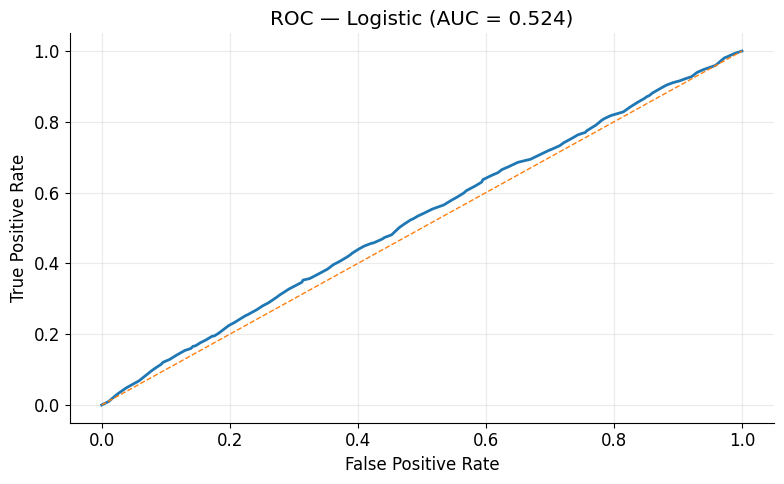

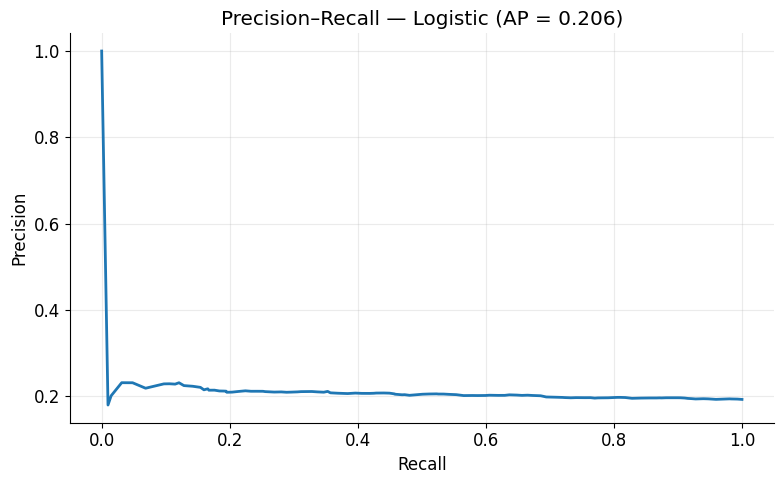

In [ ]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

best_pipe = grid.best_estimator_ if 'grid' in globals() else pipe_lr
p_test = best_pipe.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, thr = roc_curve(y_test, p_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC — Logistic (AUC = {roc_auc:.3f})')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_roc_logistic.png', dpi=200); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, p_test)
ap = average_precision_score(y_test, p_test)

plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'Precision–Recall — Logistic (AP = {ap:.3f})')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_pr_logistic.png', dpi=200); plt.show()


## Calibration (reliability)

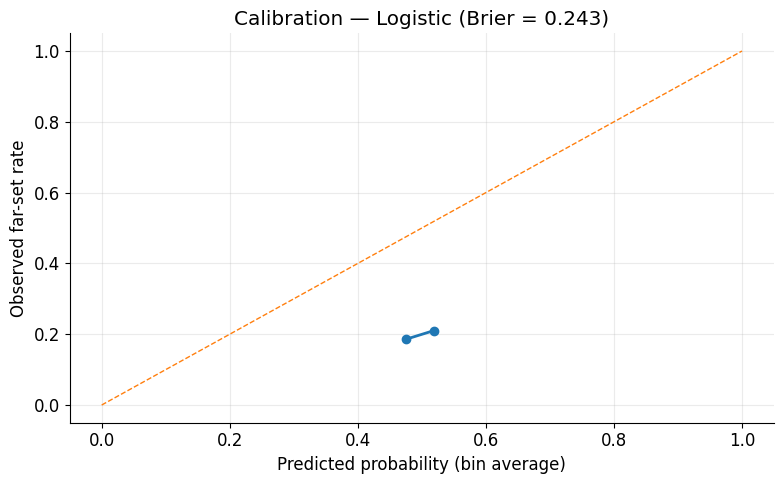

In [ ]:

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, p_test)
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy='uniform')

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('Predicted probability (bin average)')
plt.ylabel('Observed far-set rate')
plt.title(f'Calibration — Logistic (Brier = {brier:.3f})')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_calibration_logistic.png', dpi=200); plt.show()


## Chosen threshold on ROC (Youden J)

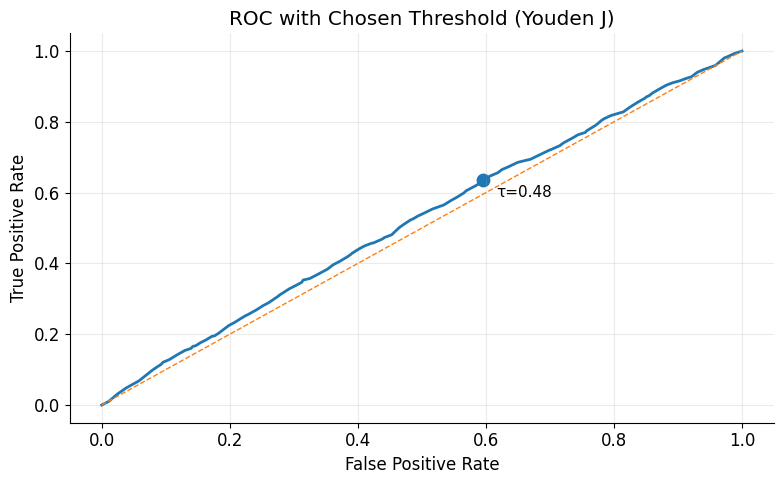

In [ ]:

from sklearn.metrics import roc_curve

def pick_threshold(y_true, p, method='youden'):
    fpr, tpr, thr = roc_curve(y_true, p)
    j = tpr - fpr
    return float(thr[j.argmax()]), float(fpr[j.argmax()]), float(tpr[j.argmax()])

t_star, fpr_star, tpr_star = pick_threshold(y_test, p_test, method='youden')

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.scatter([fpr_star], [tpr_star], s=80)
plt.text(fpr_star+0.02, tpr_star-0.05, f'τ={t_star:.2f}', fontsize=11)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC with Chosen Threshold (Youden J)')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_roc_threshold.png', dpi=200); plt.show()


## Decile lift (coach-friendly stratification)

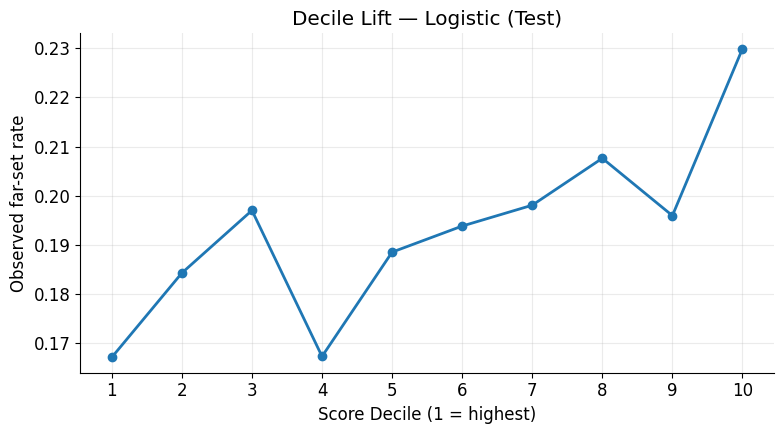

In [ ]:

import numpy as np, pandas as pd

def decile_table(y, p):
    dfp = pd.DataFrame({'y': y, 'p': p}).sort_values('p', ascending=False)
    dfp['decile'] = pd.qcut(dfp['p'].rank(method='first'), 10, labels=False) + 1
    return (dfp.groupby('decile')
            .agg(n=('y','size'), far_rate=('y','mean'), p_avg=('p','mean'))
            .reset_index())

dec = decile_table(y_test, p_test)
dec.to_csv(OUTDIR/'decile_lift_logistic.csv', index=False)

plt.figure(figsize=(8,4.5))
plt.plot(dec['decile'], dec['far_rate'], marker='o', linewidth=2)
plt.xlabel('Score Decile (1 = highest)')
plt.ylabel('Observed far-set rate')
plt.title('Decile Lift — Logistic (Test)')
plt.xticks(dec['decile'])
plt.tight_layout(); plt.savefig(OUTDIR/'fig_decile_lift.png', dpi=200); plt.show()


## Interpretation: permutation importance & odds ratios

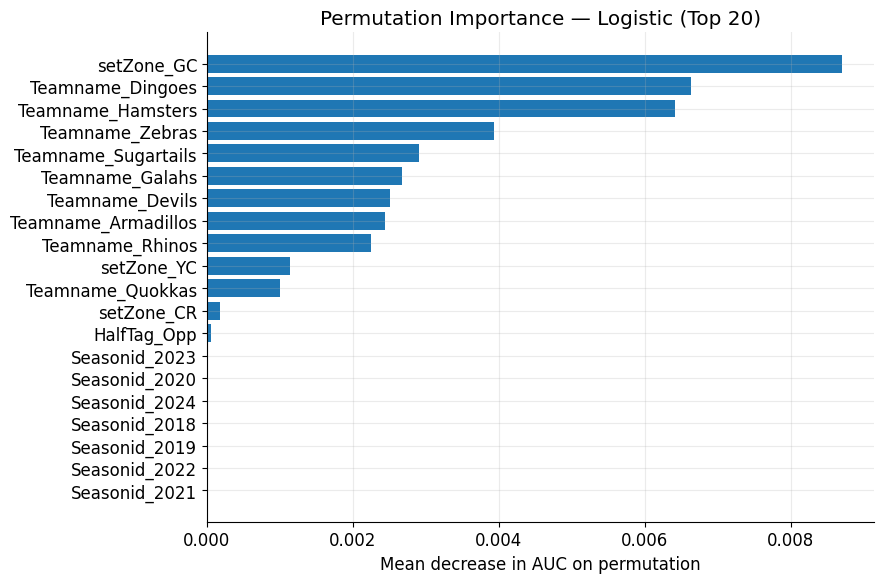

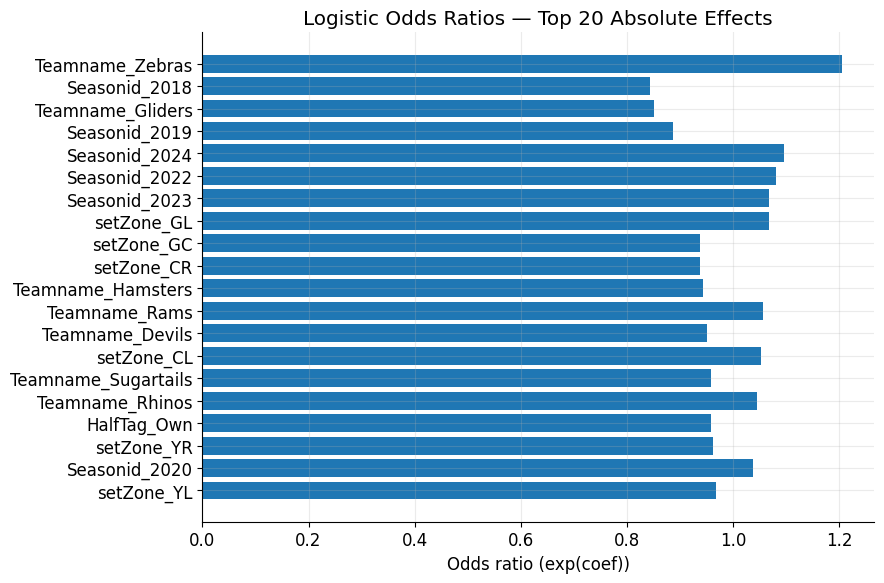

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np, pandas as pd

prep  = best_pipe.named_steps['prep']
model = best_pipe.named_steps['model']
X_test_tx = prep.transform(X_test)
feat_names = prep.named_transformers_['onehot'].get_feature_names_out(features)

# Permutation importance
perm = permutation_importance(model, X_test_tx.toarray(), y_test, n_repeats=10, random_state=42)
perm_df = (pd.DataFrame({'feature': feat_names,
                         'importance_mean': perm.importances_mean,
                         'importance_std':  perm.importances_std})
           .sort_values('importance_mean', ascending=False))
perm_df.to_csv(OUTDIR/'perm_importance_logistic.csv', index=False)

topk = perm_df.head(20)
plt.figure(figsize=(9,6))
ypos = np.arange(len(topk))
plt.barh(ypos, topk['importance_mean'])
plt.yticks(ypos, topk['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Mean decrease in AUC on permutation')
plt.title('Permutation Importance — Logistic (Top 20)')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_perm_importance_logistic.png', dpi=200); plt.show()

import numpy as np
coefs = model.coef_.ravel()
odds_df = (pd.DataFrame({'feature': feat_names, 'coef': coefs})
           .assign(odds_ratio=lambda d: np.exp(d['coef']),
                   abs_coef=lambda d: d['coef'].abs()))
odds_df.to_csv(OUTDIR/'logistic_odds_ratios.csv', index=False)

top = odds_df.sort_values('abs_coef', ascending=False).head(20)
plt.figure(figsize=(9,6))
ypos = np.arange(len(top))
plt.barh(ypos, top['odds_ratio'])
plt.yticks(ypos, top['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Odds ratio (exp(coef))')
plt.title('Logistic Odds Ratios — Top 20 Absolute Effects')
plt.tight_layout(); plt.savefig(OUTDIR/'fig_odds_ratios_top20.png', dpi=200); plt.show()

## League evolution: far-set rate by season & zone

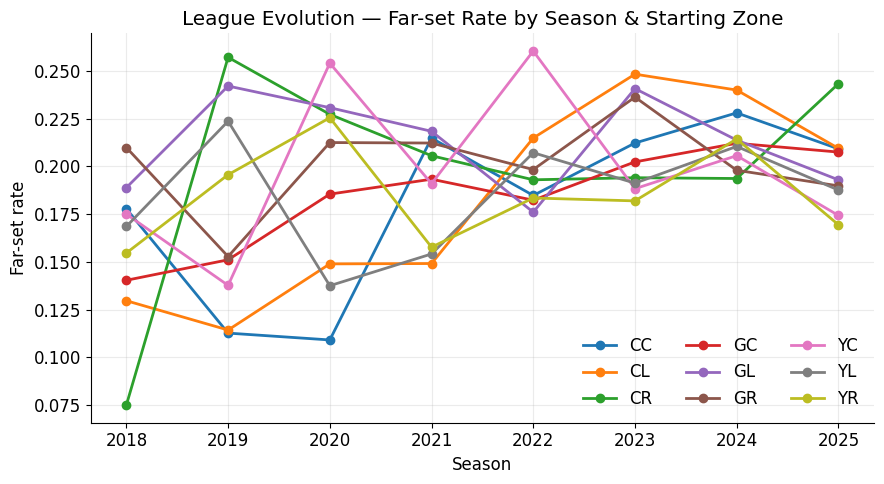

In [ ]:

df['Seasonid'] = pd.to_numeric(df['Seasonid'], errors='coerce').astype('Int64')

sz = (df.dropna(subset=['farSet_fixed'])
        .groupby(['Seasonid','setZone'])['farSet_fixed']
        .mean().reset_index())

wanted = ['Own','Mid','Opp'] if 'Own' in sz['setZone'].unique() else sorted(sz['setZone'].unique())
plt.figure(figsize=(9,5))
for z in sorted(wanted):
    g = sz[sz['setZone']==z].sort_values('Seasonid')
    plt.plot(g['Seasonid'], g['farSet_fixed'], marker='o', linewidth=2, label=z)

plt.xlabel('Season'); plt.ylabel('Far-set rate')
plt.title('League Evolution — Far-set Rate by Season & Starting Zone')
plt.legend(ncol=3, frameon=False)
plt.tight_layout(); plt.savefig(OUTDIR/'fig_evolution_season_zone.png', dpi=200); plt.show()


## Heatmap: Season × Zone far-set rates

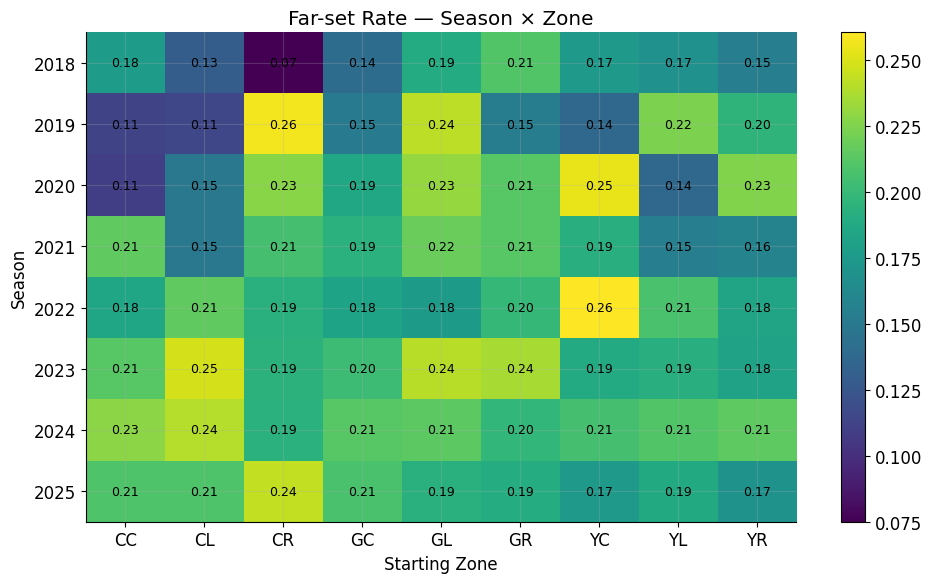

In [ ]:

tab = (df.dropna(subset=['farSet_fixed'])
         .groupby(['Seasonid','setZone'])['farSet_fixed']
         .mean().unstack(fill_value=0.0)
         .sort_index())

plt.figure(figsize=(10,6))
plt.imshow(tab.values, aspect='auto')
plt.xticks(range(tab.shape[1]), tab.columns, rotation=0)
plt.yticks(range(tab.shape[0]), tab.index)
for i in range(tab.shape[0]):
    for j in range(tab.shape[1]):
        plt.text(j, i, f"{tab.values[i,j]:.2f}", ha='center', va='center', fontsize=9)
plt.xlabel('Starting Zone'); plt.ylabel('Season')
plt.title('Far-set Rate — Season × Zone')
plt.colorbar()
plt.tight_layout(); plt.savefig(OUTDIR/'fig_heatmap_season_zone.png', dpi=200); plt.show()


### League-Wide Evolution in Performance

We now examine whether teams are advancing further over time, holding the distance benchmark fixed at 2018 levels. This avoids moving goalpost effects and allows genuine evolution to be evaluated.


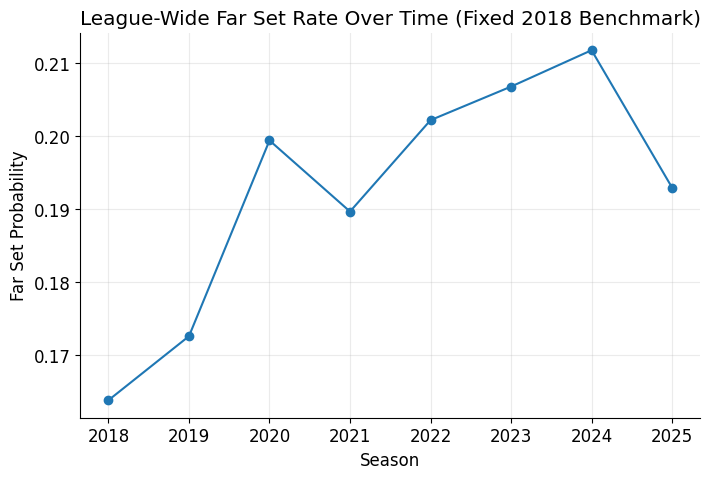

In [ ]:
season_trend = df.groupby('Seasonid')['farSet_fixed'].mean().reset_index()
plt.plot(season_trend['Seasonid'], season_trend['farSet_fixed'], marker='o')
plt.title("League-Wide Far Set Rate Over Time (Fixed 2018 Benchmark)")
plt.ylabel("Far Set Probability")
plt.xlabel("Season")
plt.show()


## Figure index

In [ ]:

with open(OUTDIR/'README_figures.txt', 'w') as f:
    f.write(
        "fig_roc_logistic.png — ROC curve (AUC)\n"
        "fig_pr_logistic.png — Precision–Recall (AP)\n"
        "fig_calibration_logistic.png — Reliability curve (Brier)\n"
        "fig_roc_threshold.png — ROC with chosen threshold\n"
        "fig_decile_lift.png — Decile lift, test season\n"
        "fig_perm_importance_logistic.png — Permutation importance (Top 20)\n"
        "fig_odds_ratios_top20.png — Logistic odds ratios (Top 20)\n"
        "fig_evolution_season_zone.png — League evolution by zone\n"
        "fig_heatmap_season_zone.png — Season × Zone heatmap\n"
    )
print('Saved figure index to:', (OUTDIR/'README_figures.txt').resolve())


Saved figure index to: /content/nrlw_farset_model_outputs/README_figures.txt
